In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

survey_data = pd.read_csv('/lirneasia/data/lacuna/raw/Survey_data/Survey_wave_1_may_29.csv', low_memory=False)
leco_all = pd.DataFrame()  

In [12]:
root_folder = '/lirneasia/data/lacuna/processed/sm_april_2024_dump'
directory = os.path.join(root_folder)

if os.path.exists(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(root_folder, file_name)
                
            leco_data = pd.read_csv(file_path, low_memory=False)

            leco_all = pd.concat([leco_all, leco_data], ignore_index=False)

else:
    print("path wrong") 

In [21]:
#For now dropping all the fields except import export

leco_filterd = leco_all[['customerref', 'importkwh(kwh)', 'exportkwh(kwh)']].copy()

In [25]:
final = pd.merge(leco_filterd, survey_data, left_on='customerref', right_on='ACCOUNT_NO', how='inner')

In [40]:
leco_all['consumption'] = leco_all.groupby('customerref')['importkwh(kwh)'].diff().fillna(0)


In [41]:
leco_all['datetime'] = pd.to_datetime(leco_all['date'] + ' ' + leco_all['time'])
leco_all = leco_all.drop(columns=['date', 'time'])
leco_all = leco_all.sort_values(by=['customerref', 'datetime'])
#leco_all['meter_reading'] = pd.to_numeric(data['meter_reading'], errors='coerce')


# Resample to hourly, daily, and weekly intervals
hourly_data = leco_all.set_index('datetime').groupby('customerref')['importkwh(kwh)'].resample('H').sum().reset_index()
daily_data = leco_all.set_index('datetime').groupby('customerref')['importkwh(kwh)'].resample('D').sum().reset_index()
weekly_data = leco_all.set_index('datetime').groupby('customerref')['importkwh(kwh)'].resample('W').sum().reset_index()


/tmp/ipykernel_54731/613988830.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = leco_all.set_index('datetime').groupby('customerref')['importkwh(kwh)'].resample('H').sum().reset_index()


In [42]:
# Find daily peaks
daily_peaks = leco_all.set_index('datetime').groupby('customerref')['importkwh(kwh)'].resample('D').max().reset_index()

# Find the time of peak consumption each day
peak_times = leco_all.loc[leco_all.groupby([leco_all['customerref'], leco_all['datetime'].dt.date])['importkwh(kwh)'].idxmax()]


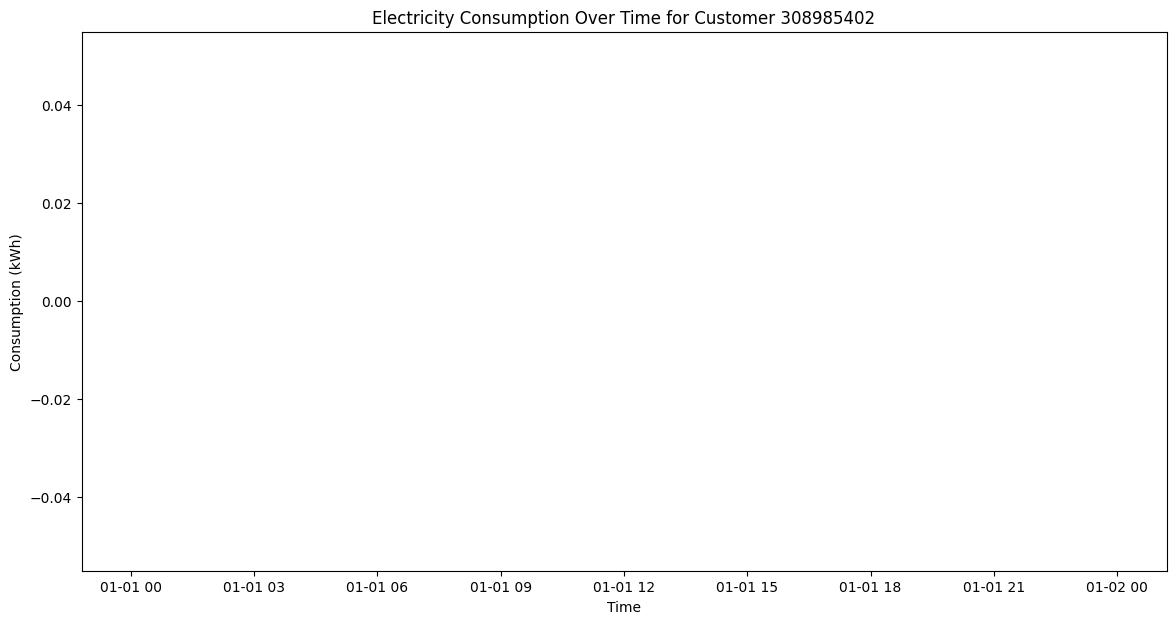

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plot for a specific customer
customer_id = '308985402'  # replace with actual customer ID
customer_data = leco_all[leco_all['customerref'] == customer_id]

plt.figure(figsize=(14, 7))
plt.plot(customer_data['datetime'], customer_data['importkwh(kwh)'])
plt.title('Electricity Consumption Over Time for Customer ' + customer_id)
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.show()

# Histogram of peak consumption times
plt.figure(figsize=(10, 6))
sns.histplot(peak_times['datetime'].dt.hour, bins=24)
plt.title('Distribution of Peak Consumption Times')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# Heatmap of average daily consumption
heatmap_data = leco_all.pivot_table(values='importkwh(kwh)', index=leco_all['datetime'].dt.hour, columns=leco_all['datetime'].dt.date, aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Average Consumption (kWh)'})
plt.title('Heatmap of Average Daily Consumption')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.show()


In [30]:
#summary_table = data.groupby(['customerref', 'year_month']).size().reset_index(name='counts')
df = final.groupby(['time', 'importkwh(kwh)']).size()

df

KeyError: 'time'